<a href="https://colab.research.google.com/github/ninazahn/Geospatial-Clustering-Analysis-on-Crimes-in-Denmark/blob/main/Geospatial_Clustering_Analysis_on_Crimes_in_Denmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Imports

In [ ]:
!pip install kneed
!pip install geopandas
!pip install yellowbrick

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from kneed import DataGenerator, KneeLocator
from yellowbrick.cluster import KElbowVisualizer
import scipy.cluster.hierarchy as sch
from scipy import stats
import random

### DATASET

####Parse and clean data

Read Data

In [ ]:
df_offences = pd.read_csv("offences.csv", encoding='windows_1252', header=None, skiprows=1, names=['MCP', 'RAPE', 'HOMICIDE', 'ASSAULT', 'THREATS', 'FORGERY', 'ARSON', 'BURGLARIES', 'FRAUD', 'ROBBERY', 'TOTAL_OFFENCES'])
df_population = pd.read_csv("population.csv", encoding='windows_1252', header=None, names=['MCP', 'POPULATION'])

Merge dataframes

In [ ]:
df = df_offences.merge(df_population, on='MCP', how='inner')

drop duplicates

In [ ]:
df.drop_duplicates(subset=['MCP'], keep='first', inplace=True)

check for NaN values

In [ ]:
df.isnull().values.any()

False

check if total number of offenses matches up

In [ ]:
for x in df.iterrows():
  if sum(x[1][1:-2]) != x[1][-2]:
    print('false: ', x)

create dataframe with crimes per 100.000 inhabitants

In [ ]:
df_pht = df.copy()
df_pht.set_index('MCP', inplace=True)
df_pht = df_pht.apply(lambda x: x/x['POPULATION']*100000, axis=1)
df_pht

,RAPE,HOMICIDE,ASSAULT,THREATS,FORGERY,ARSON,BURGLARIES,FRAUD,ROBBERY,TOTAL_OFFENCES,POPULATION
MCP,,,,,,,,,,,
Copenhagen,75.65,0.47,50.17,132.70,51.58,19.69,128.48,699.59,56.89,1215.22,100000.00
Frederiksberg,23.21,0.97,29.01,74.45,18.37,13.54,122.80,424.48,36.74,743.56,100000.00
Dragør,13.71,0.00,20.57,61.70,13.71,27.42,219.37,212.52,6.86,575.86,100000.00
Tårnby,14.06,0.00,44.53,107.80,234.34,16.40,217.94,321.05,28.12,984.24,100000.00
Albertslund,51.34,3.67,47.67,117.34,25.67,33.00,300.69,418.03,36.67,1034.08,100000.00
...,...,...,...,...,...,...,...,...,...,...,...
Morsø,19.93,0.00,14.95,54.81,64.77,49.82,189.33,269.05,4.98,667.65,100000.00
Rebild,13.09,0.00,9.82,29.46,6.55,6.55,117.82,94.91,0.00,278.19,100000.00
Thisted,32.46,0.00,16.23,64.91,9.27,6.95,136.78,127.50,9.27,403.38,100000.00


####Statistics

general statistics

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_pht.iloc[:, :-2].describe().transpose().sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
BURGLARIES,99.00,267.68,143.38,0.00,193.04,233.88,332.46,866.27
FRAUD,99.00,260.68,148.22,0.00,163.83,222.15,334.37,979.54
THREATS,99.00,84.53,39.22,0.00,63.94,78.67,99.30,262.75
RAPE,99.00,27.87,31.38,0.00,17.23,23.21,30.89,296.22
ASSAULT,99.00,22.87,12.63,0.00,14.04,20.57,31.19,58.95
FORGERY,99.00,18.88,27.41,0.00,6.65,12.08,22.25,234.34
ARSON,99.00,18.31,16.60,0.00,6.75,13.75,24.03,77.92
ROBBERY,99.00,14.07,10.56,0.00,5.93,11.95,19.56,56.89
HOMICIDE,99.00,0.51,1.08,0.00,0.00,0.00,0.23,4.86


variable distribution

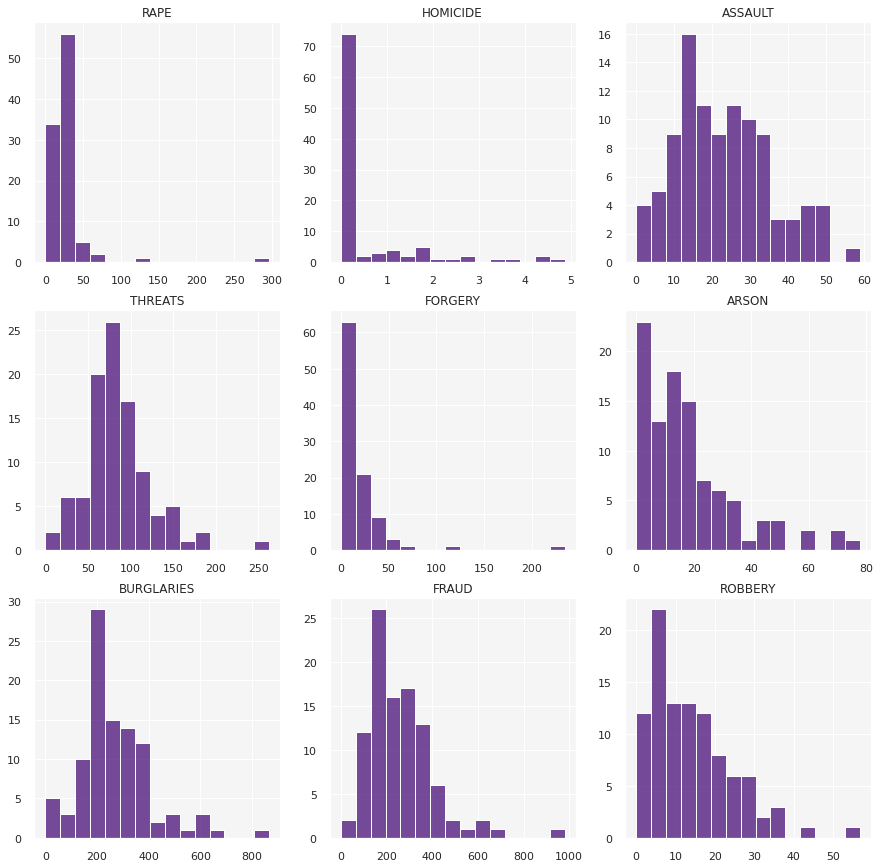

In [ ]:
fig = plt.figure(figsize=(15,15))
subplot_positions = [331, 332, 333, 334, 335, 336, 337, 338, 339]
columns = df_pht.iloc[:, :-2].columns
titles = columns.values
sns.set()

for idx, col in enumerate(columns):
  ax = fig.add_subplot(subplot_positions[idx])
  p = sns.histplot(df_pht, x=col, bins=15, ax=ax, color='#491078')
  p.set_facecolor('whitesmoke')
  p.set(title=col, xlabel=None, ylabel=None)

variable distribution by state

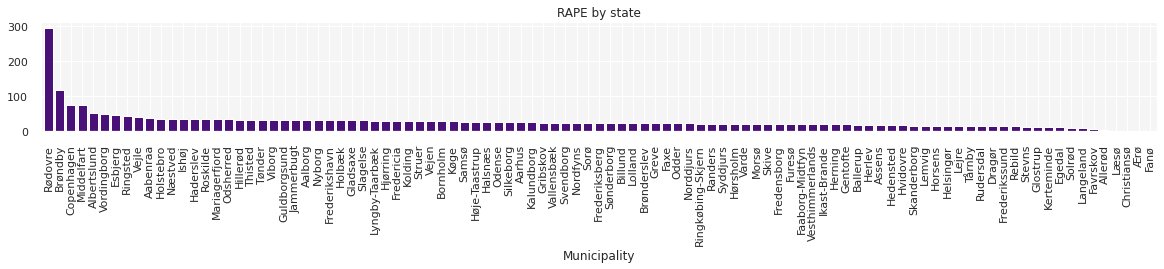

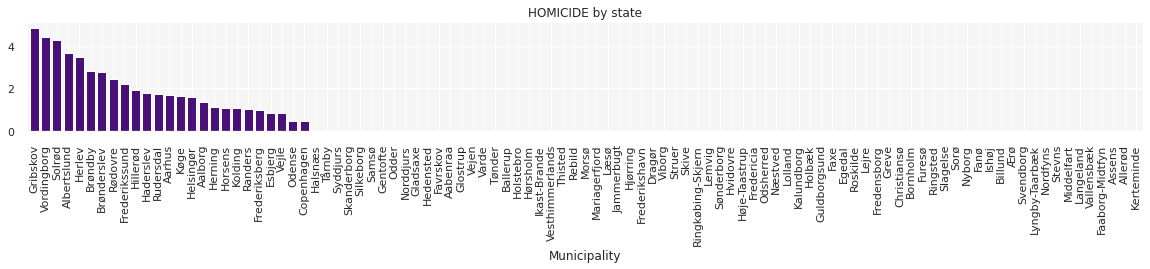

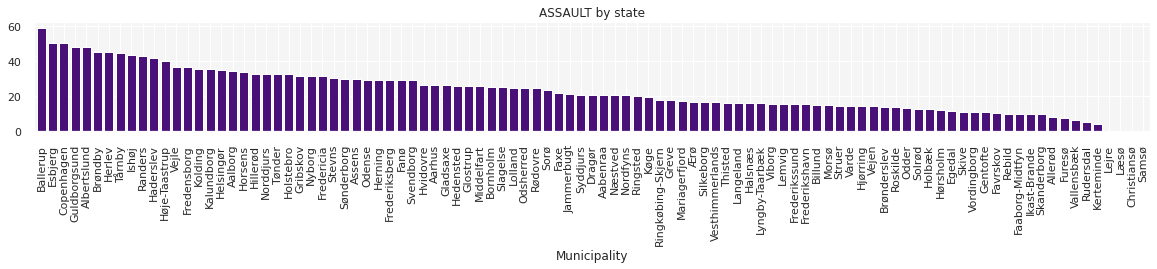

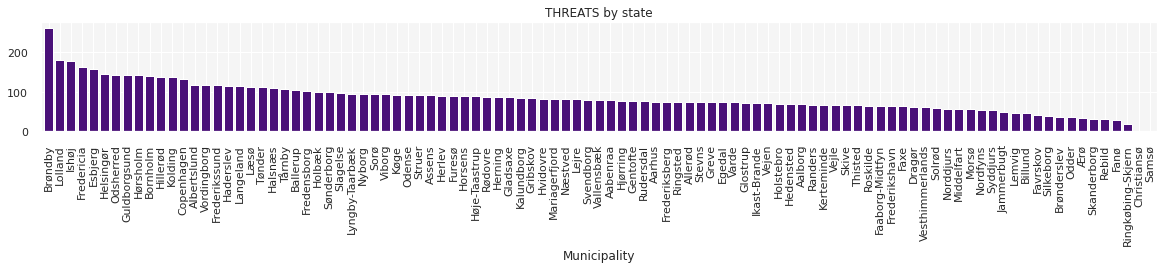

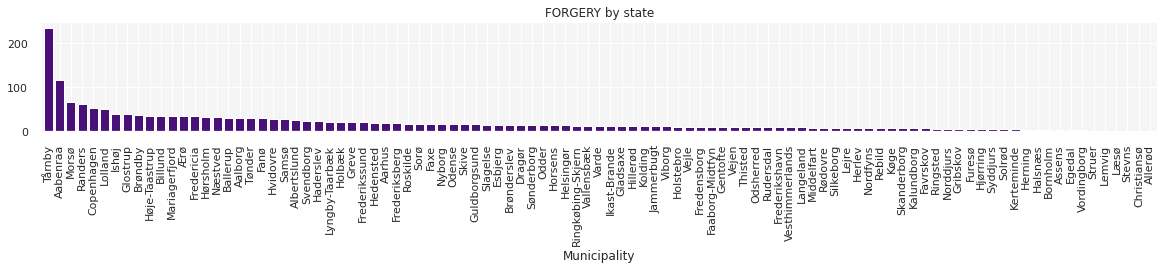

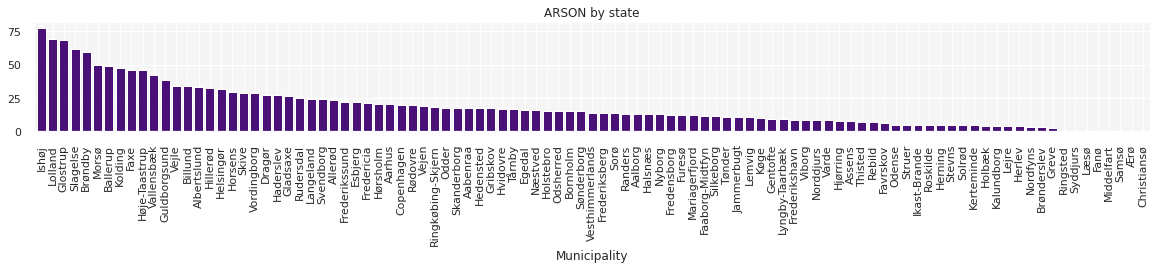

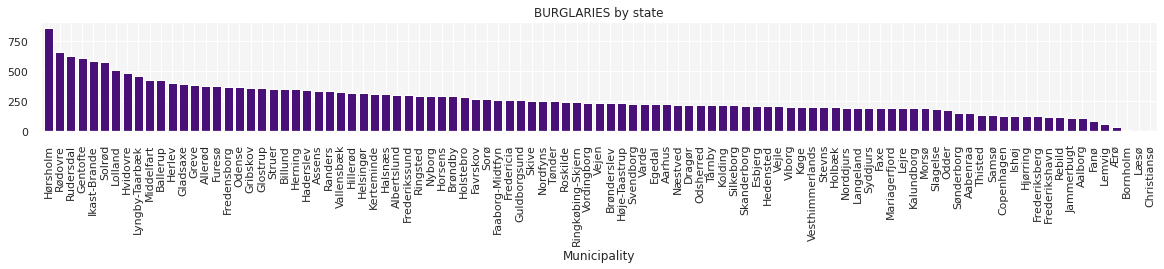

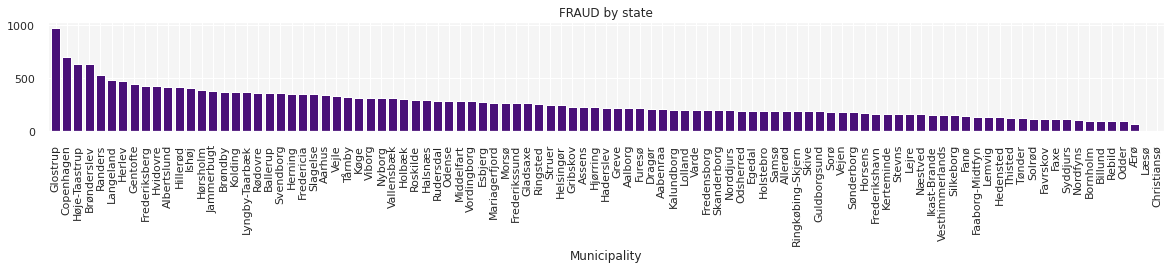

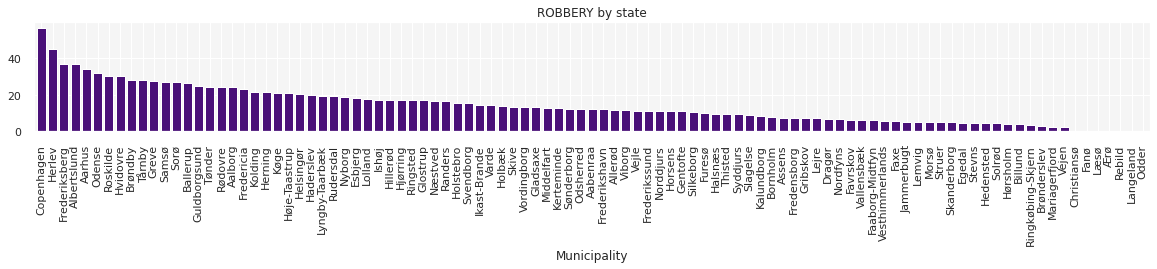

In [ ]:
for col in df_pht.iloc[:, :-2].columns:
  d = df_pht.sort_values(col, ascending=False)
  p = d.plot(y=col, kind='bar', figsize=(20,2), width=0.8, title=col+' by state', legend=None, color='#491078')
  p.set_facecolor('whitesmoke')
  plt.xlabel('Municipality')

variable correlations

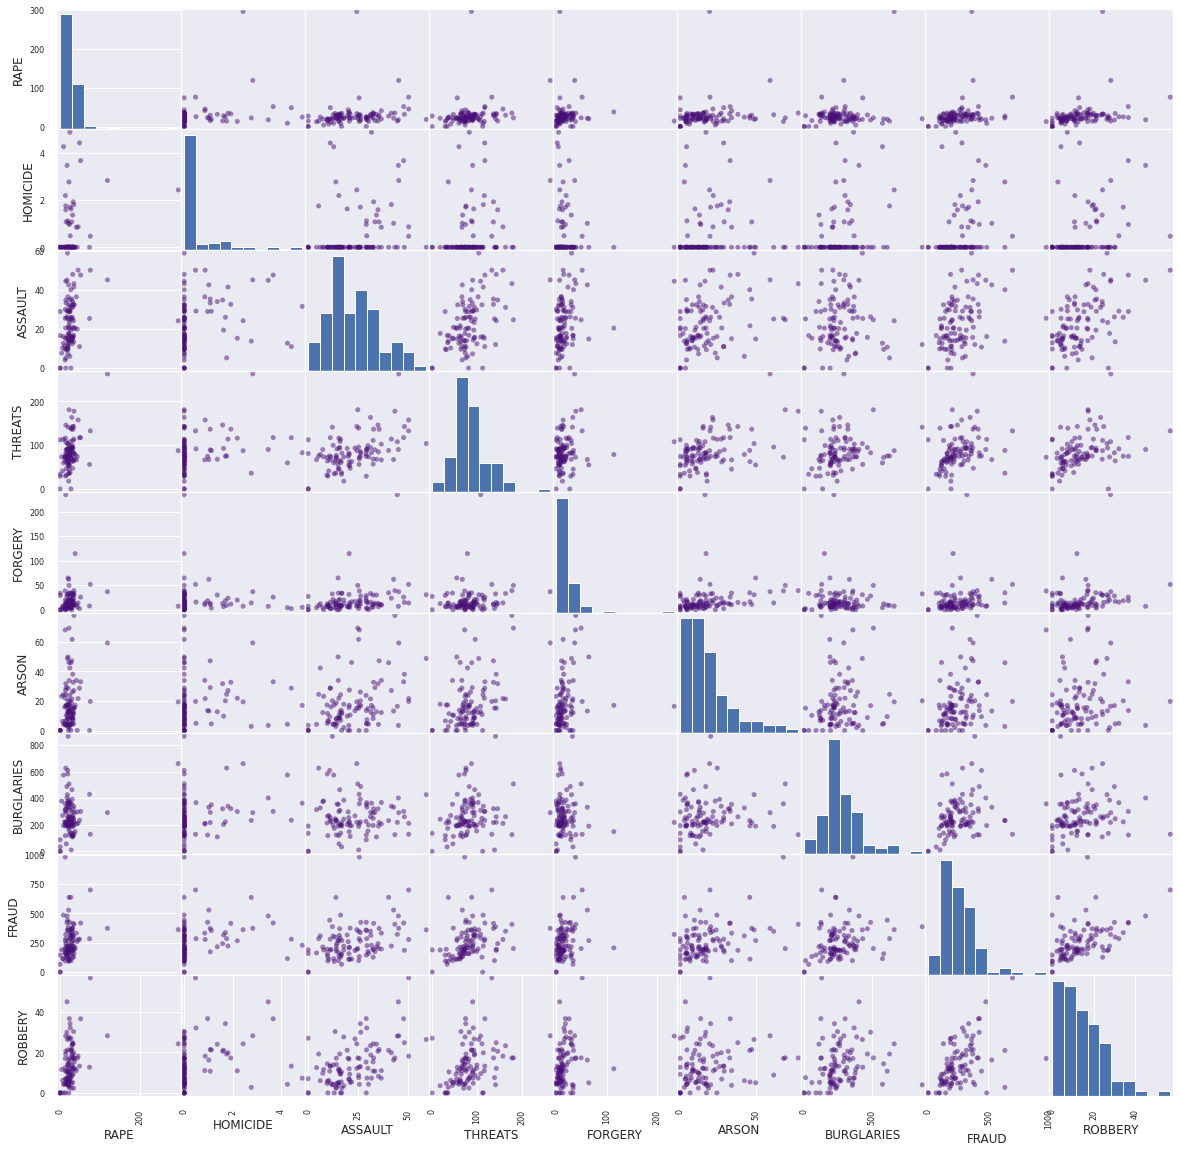

In [ ]:
cmap = LinearSegmentedColormap.from_list('colors', ['#feaa74', '#491078'], N=2)
p = pd.plotting.scatter_matrix(df_pht.iloc[:, :-2], figsize=(20,20), color='#491078', s=100)

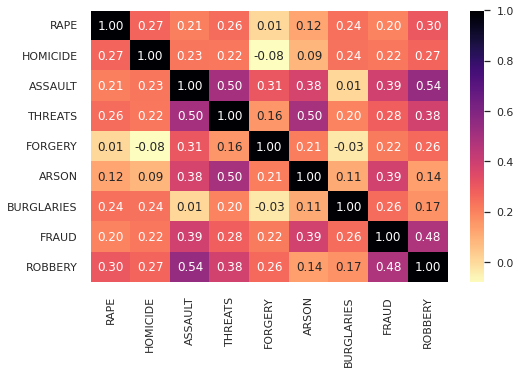

In [ ]:
sns.set(rc = {'figure.figsize':(8,5)})
sns.heatmap(df_pht.iloc[:,:-2].corr(), annot=True, fmt=".2f", cmap='magma_r')

###EXPERIMENTS

#####Preprocessing

detect and remove outliers with threshold = 3

In [ ]:
idxs = set()
for col in df_pht.iloc[:, :-2].columns:
  z = np.abs(stats.zscore(df_pht[col]))
  # Position of the outlier
  outlier = np.where(z > 3)[0]
  for idx in outlier:
    idxs.add(idx)

df.drop(df.index[list(idxs)], inplace=True)
df_population.drop(df_population.index[list(idxs)], inplace=True)
df_pht.drop(df_pht.index[list(idxs)], inplace=True)

model the distributions of the variables as a Normal Distribution

In [ ]:
df_standardized = pd.DataFrame(preprocessing.scale(df_pht.iloc[:, :-2]))
df_standardized

,0,1,2,3,4,5,6,7,8
0,-0.03,0.77,0.57,-0.14,0.33,-0.18,-1.08,1.46,2.40
1,-0.88,-0.46,-0.12,-0.53,-0.06,0.84,-0.28,-0.26,-0.67
2,2.49,4.21,2.10,1.19,0.95,1.25,0.40,1.41,2.39
3,-0.47,-0.46,3.02,0.77,1.36,2.42,1.44,0.94,1.34
4,-0.42,-0.46,-0.92,-0.11,-0.42,-0.49,2.96,1.60,-0.27
...,...,...,...,...,...,...,...,...,...
82,-0.32,-0.46,-0.58,-0.75,4.25,2.50,-0.53,0.20,-0.86
83,-0.93,-0.46,-1.00,-1.54,-0.66,-0.70,-1.13,-1.21,-1.37
84,0.80,-0.46,-0.48,-0.44,-0.43,-0.67,-0.97,-0.95,-0.42
85,-0.38,-0.46,-0.45,-0.57,-0.52,-0.17,-0.44,-0.73,-0.81


####KMeans Clustering

In [ ]:
#create a list for the wcss parameter
wcss = []
#test with 14 clusters
for i in range(1, 15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 11)
    kmeans.fit(df_standardized)
    wcss.append(kmeans.inertia_)

In [ ]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 15):
  kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 11)
  kmeans.fit(df_standardized)
  score = silhouette_score(df_standardized, kmeans.labels_)
  silhouette_coefficients.append(score)

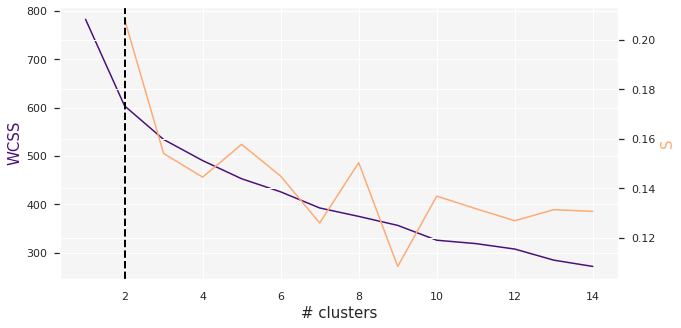

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.set_xlabel('# clusters', fontsize=15)
ax1.set_ylabel('WCSS', color='#491078', fontsize=15)
ax1.plot(range(1,15), wcss, color='#491078')
ax1.set_facecolor('whitesmoke')

ax2 = ax1.twinx()
ax2.set_ylabel('S', color='#feaa74', fontsize=15)
ax2.plot(range(2, 15), silhouette_coefficients, color='#feaa74')
ax2.set_facecolor('whitesmoke')

plt.axvline(x=2, ymin=0, ymax=780, color='black', ls='--', lw=2)
plt.show()

In [ ]:
km = KMeans(
    n_clusters=2, init='k-means++', random_state=11)
y_km = km.fit(np.array(df_standardized))

print(len(y_km.labels_))
df_pht['CLUSTER_K'] = ''
df_pht.reset_index(inplace=True)
for idx, c in enumerate(y_km.labels_):
   print(idx, c)
   df_pht.loc[idx, 'CLUSTER_K'] = c

df_pht['CLUSTER_K'] = df_pht['CLUSTER_K'].apply(lambda x: x+1)

####Agglomerative Clustering

compare different combinations of linkage and distance metrics

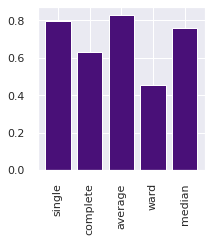

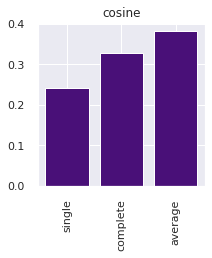

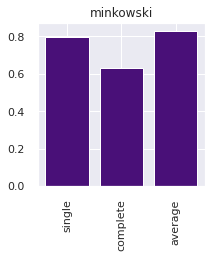

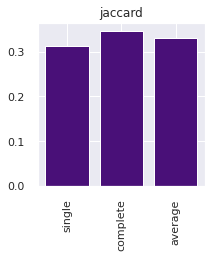

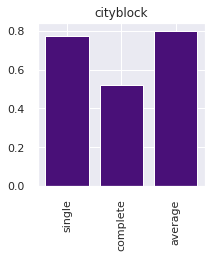

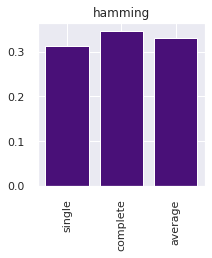

In [ ]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist


linkage = ['single', 'complete', 'average', 'ward', 'median']
cophenets = []
for l in linkage:
  Z = sch.linkage(X, method=l, metric='euclidean')
  c, coph_dists = cophenet(Z, pdist(X))
  cophenets.append(c)
fig = plt.figure(figsize=(3,3))
plt.xticks(rotation=90)
plt.bar(x=linkage, height=cophenets, color='#491078')
ax1.set_title('euclidean')
plt.show()

linkage = ['single', 'complete', 'average']
cophenets = []
for l in linkage:
  Z = sch.linkage(X, method=l, metric='cosine')
  c, coph_dists = cophenet(Z, pdist(X))
  cophenets.append(c)
fig = plt.figure(figsize=(3,3))
plt.xticks(rotation=90)
plt.bar(x=linkage, height=cophenets, color='#491078')
plt.title('cosine')
plt.show()


linkage = ['single', 'complete', 'average']
cophenets = []
for l in linkage:
  Z = sch.linkage(X, method=l, metric='minkowski')
  c, coph_dists = cophenet(Z, pdist(X))
  cophenets.append(c)
fig = plt.figure(figsize=(3,3))
plt.xticks(rotation=90)
plt.bar(x=linkage, height=cophenets, color='#491078')
plt.title('minkowski')
plt.show()


linkage = ['single', 'complete', 'average']
cophenets = []

for l in linkage:
  Z = sch.linkage(X, method=l, metric='jaccard')
  c, coph_dists = cophenet(Z, pdist(X))
  cophenets.append(c)

fig = plt.figure(figsize=(3,3))
plt.xticks(rotation=90)
plt.bar(x=linkage, height=cophenets, color='#491078')
plt.title('jaccard')
plt.show()


linkage = ['single', 'complete', 'average']
cophenets = []

for l in linkage:
  Z = sch.linkage(X, method=l, metric='cityblock')
  c, coph_dists = cophenet(Z, pdist(X))
  cophenets.append(c)

fig = plt.figure(figsize=(3,3))
plt.xticks(rotation=90)
plt.bar(x=linkage, height=cophenets, color='#491078')
plt.title('cityblock')
plt.show()

linkage = ['single', 'complete', 'average']
cophenets = []

for l in linkage:
  Z = sch.linkage(X, method=l, metric='hamming')
  c, coph_dists = cophenet(Z, pdist(X))
  cophenets.append(c)

fig = plt.figure(figsize=(3,3))
plt.xticks(rotation=90)
plt.bar(x=linkage, height=cophenets, color='#491078')
plt.title('hamming')
plt.show()

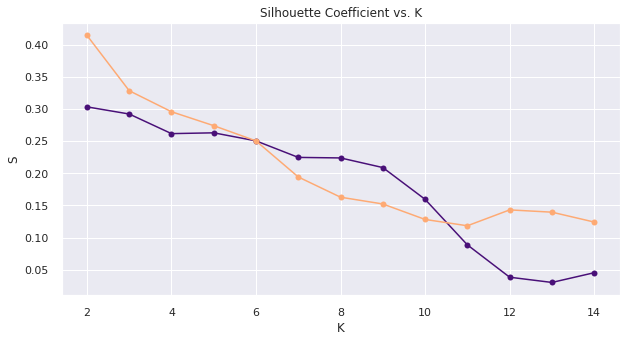

In [ ]:
# A list holds the silhouette coefficients for each k
silhouette_coeff_single = []
silhouette_coeff_average = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 15):
  hmeans = AgglomerativeClustering(affinity='euclidean', linkage='single', n_clusters=k)
  hmeans.fit(df_standardized)
  score = silhouette_score(df_standardized, hmeans.labels_)
  silhouette_coeff_single.append(score)

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 15):
  hmeans = AgglomerativeClustering(affinity='euclidean', linkage='average', n_clusters=k)
  hmeans.fit(df_standardized)
  score = silhouette_score(df_standardized, hmeans.labels_)
  silhouette_coeff_average.append(score)


plt.figure(figsize=(10,5));
plt.plot(range(2,15), silhouette_coeff_single, linestyle="-", marker="o", color="#491078")
plt.plot(range(2,15), silhouette_coeff_average, linestyle="-", marker="o", color="#feaa74")
plt.xlabel("K")
plt.ylabel("S")
plt.title("Silhouette Coefficient vs. K")
plt.show()

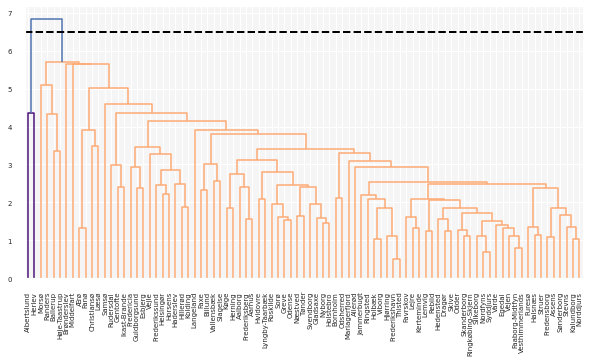

In [ ]:
X = df_standardized.iloc[:, :].values
fig = plt.figure(figsize=(10,5))
from scipy.cluster import hierarchy
hierarchy.set_link_color_palette(['#491078', '#feaa74'])
dendogram = sch.dendrogram(sch.linkage(X, method='average'), orientation='top', labels=df_pht.MCP.values, color_threshold=6)
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=7)
ax.tick_params(axis='y', which='major', labelsize=7)
ax.set_facecolor('whitesmoke')

plt.axhline(y=6.5, color='black', ls='--', lw=2)

In [ ]:
model = AgglomerativeClustering(affinity='euclidean', linkage='average')
model.fit(X)
y_agg_labels = model.labels_

df_pht['CLUSTER_A'] = ''
for idx, c in enumerate(y_agg_labels):
  df_pht.loc[idx, 'CLUSTER_A'] = c

df_pht.CLUSTER_A = df_pht['CLUSTER_A'].apply(lambda x: x+1)

####Analysis and Comparison

mean values of each variable per cluster and algorithm

In [ ]:
df_pht.groupby('CLUSTER_A').mean()

,RAPE,HOMICIDE,ASSAULT,THREATS,FORGERY,ARSON,BURGLARIES,FRAUD,ROBBERY,TOTAL_OFFENCES,POPULATION,CLUSTER_K
CLUSTER_A,,,,,,,,,,,,
1,23.26,0.28,21.48,78.36,14.37,15.98,250.86,239.42,12.72,656.74,100000.00,1.46
2,34.33,3.57,46.35,103.71,16.30,18.23,351.27,448.05,40.85,1062.67,100000.00,2.00


In [ ]:
df_pht.sort_values('CLUSTER_A', ascending=False)

,MCP,RAPE,HOMICIDE,ASSAULT,THREATS,FORGERY,ARSON,BURGLARIES,FRAUD,ROBBERY,TOTAL_OFFENCES,POPULATION,CLUSTER_K,CLUSTER_A
2,Albertslund,51.34,3.67,47.67,117.34,25.67,33.00,300.69,418.03,36.67,1034.08,100000.00,2,2
6,Herlev,17.32,3.46,45.04,90.07,6.93,3.46,401.86,478.07,45.04,1091.25,100000.00,2,2
0,Frederiksberg,23.21,0.97,29.01,74.45,18.37,13.54,122.80,424.48,36.74,743.56,100000.00,2,1
56,Vejle,40.77,0.85,36.52,66.25,10.19,33.98,206.40,332.11,11.04,738.12,100000.00,2,1
64,Silkeborg,24.96,0.00,16.64,37.44,7.28,11.44,216.30,148.70,10.40,473.15,100000.00,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,Kalundborg,24.77,0.00,35.09,84.63,6.19,4.13,189.90,202.28,8.26,555.24,100000.00,1,1
28,Holbæk,30.44,0.00,12.45,99.62,20.75,4.15,197.86,307.16,13.84,686.27,100000.00,1,1
27,Guldborgsund,31.47,0.00,48.04,142.46,14.91,38.10,260.08,185.53,24.85,745.44,100000.00,2,1
26,Faxe,21.69,0.00,21.69,62.35,16.26,46.08,192.47,111.14,5.42,477.10,100000.00,1,1


In [ ]:
df_pht.groupby('CLUSTER_K').mean()

,RAPE,HOMICIDE,ASSAULT,THREATS,FORGERY,ARSON,BURGLARIES,FRAUD,ROBBERY,TOTAL_OFFENCES,POPULATION,CLUSTER_A
CLUSTER_K,,,,,,,,,,,,
1,19.26,0.00,15.51,65.36,10.26,12.08,207.68,178.97,7.31,516.43,100000.00,1.00
2,28.29,0.76,29.38,94.18,19.08,20.48,304.21,317.43,20.17,833.97,100000.00,1.05


In [ ]:
df_pht.sort_values('CLUSTER_K', ascending=False)

,MCP,RAPE,HOMICIDE,ASSAULT,THREATS,FORGERY,ARSON,BURGLARIES,FRAUD,ROBBERY,TOTAL_OFFENCES,POPULATION,CLUSTER_K,CLUSTER_A
0,Frederiksberg,23.21,0.97,29.01,74.45,18.37,13.54,122.80,424.48,36.74,743.56,100000.00,2,1
25,Roskilde,33.72,0.00,13.49,64.07,16.86,4.50,245.05,297.88,30.35,705.91,100000.00,2,1
30,Næstved,34.77,0.00,20.38,81.52,31.17,15.59,221.79,157.05,16.78,579.05,100000.00,2,1
31,Odsherred,33.39,0.00,24.28,142.67,9.11,15.18,218.56,194.28,12.14,649.62,100000.00,2,1
32,Ringsted,42.84,0.00,19.99,74.26,5.71,0.00,297.02,259.89,17.14,716.85,100000.00,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,Faxe,21.69,0.00,21.69,62.35,16.26,46.08,192.47,111.14,5.42,477.10,100000.00,1,1
57,Favrskov,6.18,0.00,10.30,41.18,6.18,6.18,269.76,113.26,6.18,459.20,100000.00,1,1
58,Hedensted,17.05,0.00,25.57,68.19,19.18,17.05,208.84,132.13,4.26,492.27,100000.00,1,1
60,Norddjurs,21.63,0.00,32.45,56.79,5.41,8.11,194.71,194.71,10.82,524.62,100000.00,1,1


show how both algorithms weighted the variables

In [ ]:
df_pht.corr().iloc[11:, :-4]

,RAPE,HOMICIDE,ASSAULT,THREATS,FORGERY,ARSON,BURGLARIES,FRAUD,ROBBERY
CLUSTER_K,0.40,0.48,0.57,0.45,0.37,0.31,0.40,0.56,0.66
CLUSTER_A,0.15,0.63,0.31,0.12,0.02,0.02,0.13,0.25,0.43


visualize variable distribution colored by clusters

In [ ]:
df_clustered_KMeans = (df_pht.groupby(['CLUSTER_K', 'MCP']).last()).reset_index()
df_clustered_agg = (df_pht.groupby(['CLUSTER_A', 'MCP']).last()).reset_index()

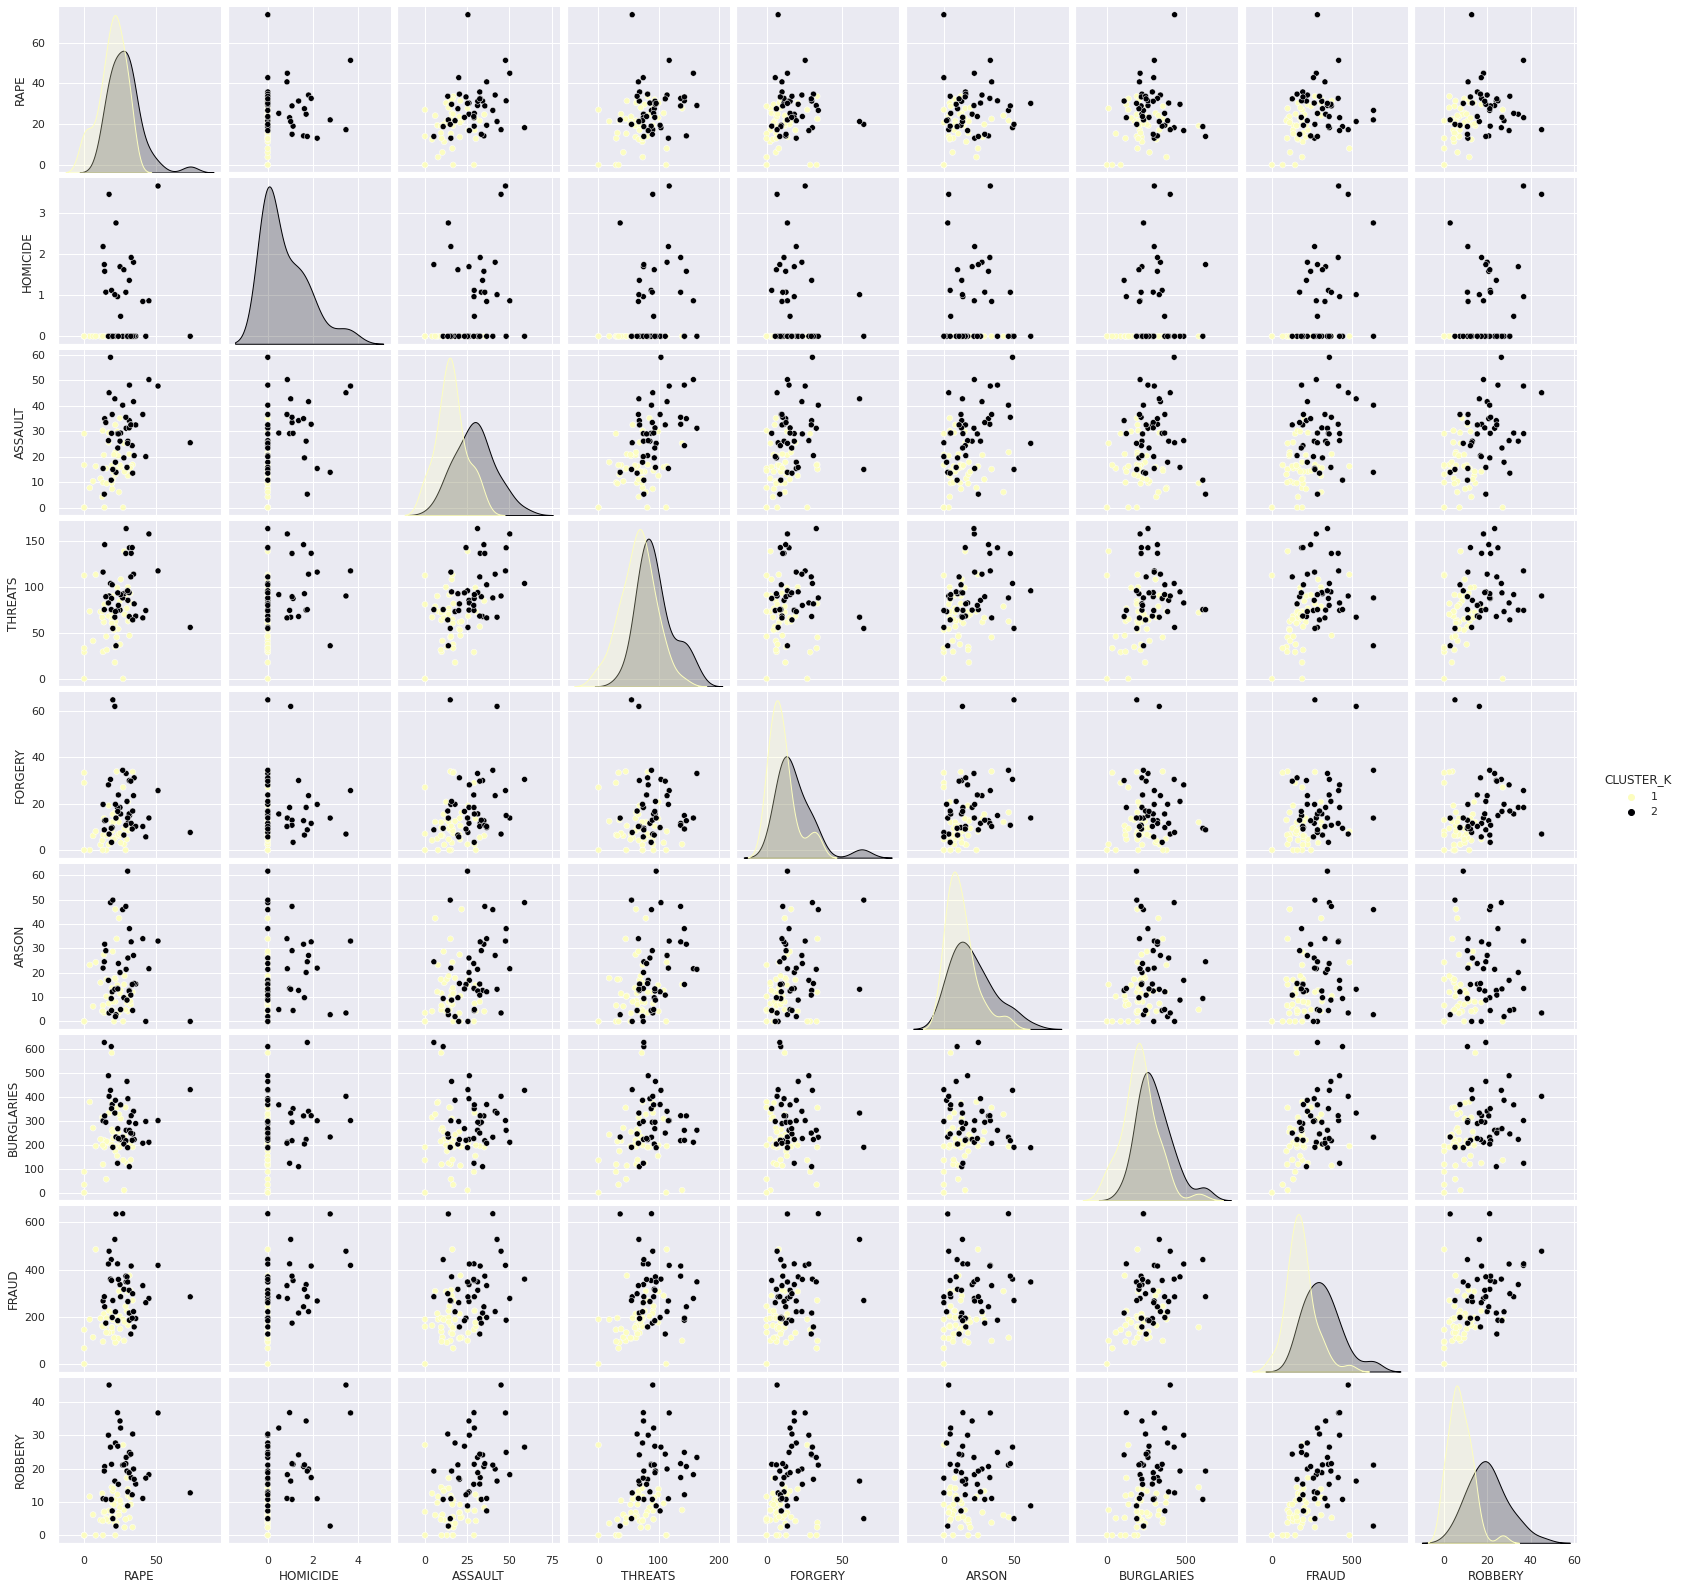

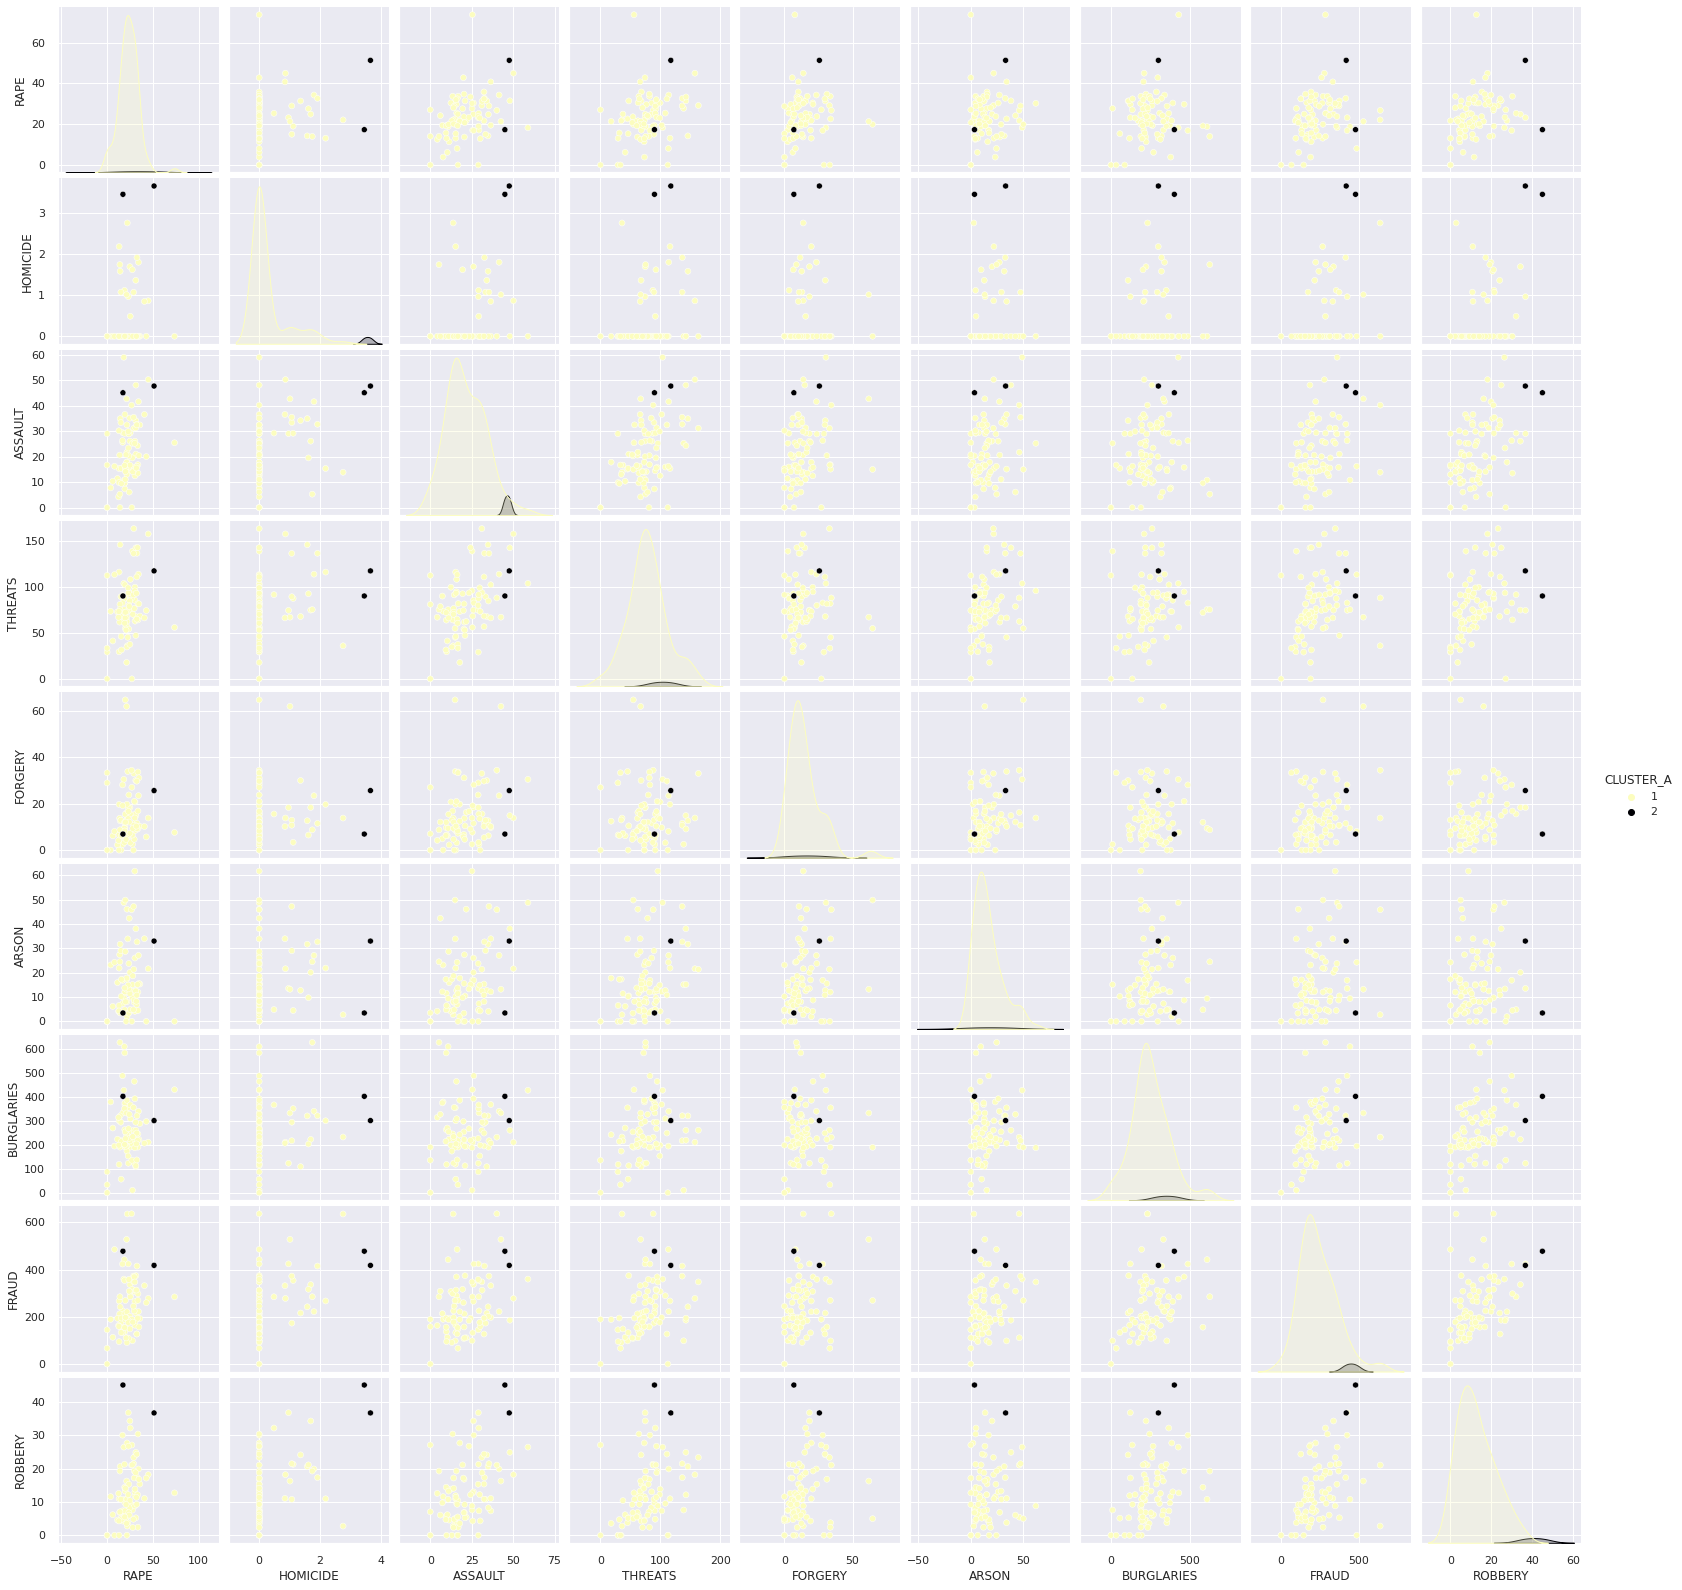

In [ ]:
cols_K = ['CLUSTER_K', 'MCP', 'RAPE', 'HOMICIDE', 'ASSAULT', 'THREATS', 'FORGERY', 'ARSON', 'BURGLARIES', 'FRAUD', 'ROBBERY']
cols_A = ['CLUSTER_A', 'MCP', 'RAPE', 'HOMICIDE', 'ASSAULT', 'THREATS', 'FORGERY', 'ARSON', 'BURGLARIES', 'FRAUD', 'ROBBERY']

cmap = LinearSegmentedColormap.from_list('colors', ['#feaa74', '#491078'], N=2)
sns.pairplot(df_clustered_KMeans[cols_K], hue='CLUSTER_K', palette='magma_r', )
sns.pairplot(df_clustered_agg[cols_A], hue='CLUSTER_A', palette='magma_r')
plt.show()

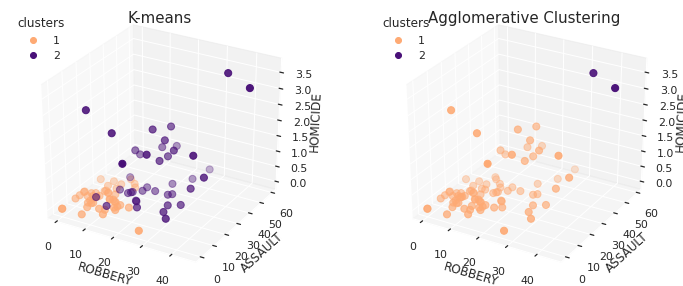

In [ ]:
fig = plt.figure(figsize=(12, 5))
cmap = LinearSegmentedColormap.from_list('colors', ['#feaa74', '#491078'], N=2)

ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(df_clustered_KMeans['ROBBERY'], df_clustered_KMeans['ASSAULT'], df_clustered_KMeans['HOMICIDE'], c=df_clustered_KMeans['CLUSTER_K'].astype('category').cat.codes, s=50, cmap=cmap)
ax1.set_facecolor('white')
ax1.set_xlabel('ROBBERY')
ax1.set_ylabel('ASSAULT')
ax1.set_zlabel('HOMICIDE')
ax1.set_title('K-means', fontsize=15)
plt.legend(handles=sc1.legend_elements()[0], labels=['1', '2'], title="clusters", loc='upper left')

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(df_clustered_agg['ROBBERY'], df_clustered_agg['ASSAULT'], df_clustered_agg['HOMICIDE'], c=df_clustered_agg['CLUSTER_A'].astype('category').cat.codes, s=50, cmap=cmap)
ax2.set_facecolor('white')
ax2.set_xlabel('ROBBERY')
ax2.set_ylabel('ASSAULT')
ax2.set_zlabel('HOMICIDE')
ax2.set_title('Agglomerative Clustering', fontsize=15)
plt.legend(handles=sc1.legend_elements()[0], labels=['1', '2'], title="clusters", loc='upper left')

plt.show()

visualise classification of MCP colored by cluster

In [ ]:
df_areas = gpd.read_file('municipalities.geojson')
df_areas.replace({'Brønderslev-Dronninglund' : 'Brønderslev'}, inplace=True)

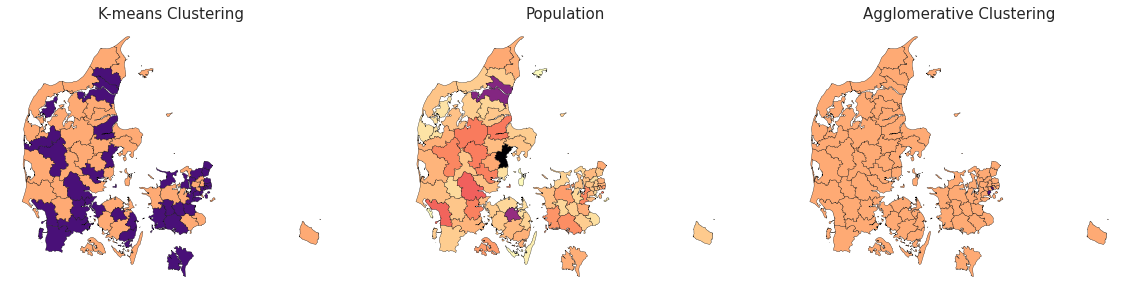

In [ ]:
df_clustered_KMeans.replace({'Vesthimmerlands' : 'Vesthimmerland', 'Copenhagen' : 'København', 'Aarhus' : 'Århus'}, inplace=True)
df_merge_KMeans = pd.merge(df_areas[['label_dk', 'geometry']], df_clustered_KMeans, how='left', left_on=['label_dk'], right_on=['MCP'])

df_clustered_agg.replace({'Vesthimmerlands' : 'Vesthimmerland', 'Copenhagen' : 'København', 'Aarhus' : 'Århus'}, inplace=True)
df_merge_agg = pd.merge(df_areas[['label_dk', 'geometry']], df_clustered_agg, how='left', left_on=['label_dk'], right_on=['MCP'])

df_population.replace({'Vesthimmerlands' : 'Vesthimmerland', 'Copenhagen' : 'København', 'Aarhus' : 'Århus'}, inplace=True)
df_merge_areas = pd.merge(df_areas[['label_dk', 'geometry']], df_population, how='inner', left_on=['label_dk'], right_on=['MCP'])


cmap = LinearSegmentedColormap.from_list('colors', ['#feaa74', '#491078'], N=2)

fig = plt.figure(figsize=(20,40))
ax1 = fig.add_subplot(131)
ax1.set_axis_off()
ax1.set_title('K-means Clustering', fontsize=15)
df_merge_KMeans.plot(column='CLUSTER_K', ax=ax1, cmap=cmap, edgecolor="black", linewidth=0.3)

ax2 = fig.add_subplot(132)
ax2.set_axis_off()
ax2.set_title('Population', fontsize=15)
df_merge_areas.plot(column='POPULATION', ax=ax2, cmap='magma_r', edgecolor="black", linewidth=0.3)

ax3 = fig.add_subplot(133)
ax3.set_axis_off()
ax3.set_title('Agglomerative Clustering', fontsize=15)
df_merge_agg.plot(column='CLUSTER_A', ax=ax3, cmap=cmap, edgecolor="black", linewidth=0.3)


plt.show()

In [ ]:
df_merge_population = pd.merge(df_population, df_pht[['MCP', 'CLUSTER_K', 'CLUSTER_A']], how='left', on='MCP')
df_merge_population.corr().iloc[1:, :-2]

,POPULATION
CLUSTER_K,0.42
CLUSTER_A,-0.10
